# Introduction

This notebook will train a very simple model that will compare two numbers and tell us if one is larger than the other.

We'll convert the model into something that can be used by tflite and then run it on the ESP32

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.data import Dataset
import numpy as np
import itertools

## Create a dataset to train our model
We'll create a python generator and feed that through a tensorflow Dataset to train our model

In [ ]:
def data_generator():
    while(True):
        number1 = np.random.uniform();
        number2 = np.random.uniform();
        # our input data is an array containing 2 numbers
        X = [number1, number2]
        # our label is 1 or 0
        Y = 1 if number2 > number1 else 0
        # our generator should return the input data and the label
        yield X, [Y]
        
# create a dataset from our generator
train_dataset = tf.data.Dataset.from_generator(
    data_generator, 
    output_types = (tf.float32, tf.int32),
    output_shapes=((2), (1))
)
train_dataset = train_dataset.batch(batch_size=30)

## Our very simple mode

We don't need a very complicated model for our problem, so we'll just define a small neural network with an input layer and an output layer.

It's important that the activation function for the output should be sigmoid. This activation function will output a value between 0 and 1.

In [ ]:
model = Sequential([
    Input(shape=(2)),
    Dense(5, activation='relu'),
    Dense(1, activation='sigmoid')
])

## Compile our model¶
For our loss function we need to use BinaryCrossentropy.

Crossentropy quantifies the difference between two probability distribution.

We have a binary distribution (True or False) so we use binary crossentropy to compare the output from our model with the true distribution.


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

In [ ]:
model.fit(
    train_dataset,
    steps_per_epoch=1000,
    epochs=4
)

## Testing our model
We can feed in some values and see what our model predicts

In [ ]:
test_X = np.array([
    [0.1, 0.2],
    [0.3, 0.4],
    [0.5, 0.1],
    [0.7, 0.2]
])
Y = model.predict_on_batch(test_X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
print(Y)

## Export our model for tflite
We need to convert our model into a tflite model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
    for _ in range(10000):
        yield [
            np.array(
                [np.random.uniform(), np.random.uniform()]
            , dtype=np.float32)
        ]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_quant_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_quant_model)

## To convert to C++
We can then run this command to convert the model to c code.
```
xxd -i converted_model.tflite > model_data.cc
```

Epoch 1/100
20/20 [==============================] - 1s 9ms/step - loss: 0.3788 - val_loss: 1.7601
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 0.3091 - val_loss: 1.3294
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2493 - val_loss: 0.8780
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1937 - val_loss: 0.6528
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1401 - val_loss: 0.5160
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0971 - val_loss: 0.2905
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0641 - val_loss: 0.1128
Epoch 8/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0404 - val_loss: 0.0495
Epoch 9/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0249 - val_loss: 0.0234
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0147 - val_loss: 0.0177
Epoch 11/

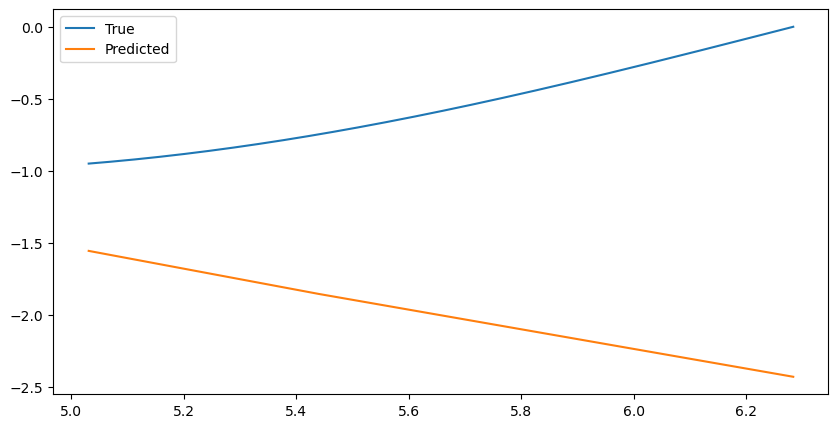

1/1 [==============================] - 0s 55ms/step
Predicted sine of 1: 0.8402467370033264


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Generate dataset
x = np.linspace(0, 2 * np.pi, 1000)
y = np.sin(x)

# Split into training and testing datasets
x_train = x[:800]
y_train = y[:800]
x_test = x[800:]
y_test = y[800:]

# Define the model
model = Sequential()
model.add(Dense(50, input_dim=1, activation='relu'))  # Input layer and first hidden layer
model.add(Dense(50, activation='relu'))  # Second hidden layer
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(x_test, y_test)
print(f'Test loss: {loss}')

# Make predictions on the test set
y_pred = model.predict(x_test)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_test, y_test, label='True')
plt.plot(x_test, y_pred, label='Predicted')
plt.legend()
plt.show()

# Predict the sine of 1
input_value = np.array([[1]])
predicted_sine = model.predict(input_value)
print(f'Predicted sine of 1: {predicted_sine[0][0]}')


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
    for _ in range(10000):
        yield [
            np.array(
                [np.random.uniform(), np.random.uniform()]
            , dtype=np.float32)
        ]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_quant_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_quant_model)

In [14]:
import math
import os

import numpy as np
import tensorflow as tf


def get_data():
  """
  The code will generate a set of random `x` values,calculate their sine
  values.
  """
  # Generate a uniformly distributed set of random numbers in the range from
  # 0 to 2π, which covers a complete sine wave oscillation
  x_values = np.random.uniform(low=0, high=2 * math.pi,
                               size=1000).astype(np.float32)

  # Shuffle the values to guarantee they're not in order
  np.random.shuffle(x_values)

  # Calculate the corresponding sine values
  y_values = np.sin(x_values).astype(np.float32)

  return (x_values, y_values)


def create_model() -> tf.keras.Model:
  model = tf.keras.Sequential()

  # First layer takes a scalar input and feeds it through 16 "neurons". The
  # neurons decide whether to activate based on the 'relu' activation function.
  model.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(1, )))

  # The new second and third layer will help the network learn more complex
  # representations
  model.add(tf.keras.layers.Dense(16, activation='relu'))

  # Final layer is a single neuron, since we want to output a single value
  model.add(tf.keras.layers.Dense(1))

  # Compile the model using the standard 'adam' optimizer and the mean squared
  # error or 'mse' loss function for regression.
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])

  return model


def convert_tflite_model(model):
  """Convert the save TF model to tflite model, then save it as .tflite flatbuffer format
    Args:
        model (tf.keras.Model): the trained hello_world Model
    Returns:
        The converted model in serialized format.
  """
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  tflite_model = converter.convert()
  return tflite_model


def save_tflite_model(tflite_model, model_name):
  """save the converted tflite model
  Args:
      tflite_model (binary): the converted model in serialized format.
      save_dir (str): the save directory
      model_name (str): model name to be saved
  """
  with open(model_name, "wb") as f:
    f.write(tflite_model)


def train_model(epochs, x_values, y_values):
  """Train keras hello_world model
    Args: epochs (int) : number of epochs to train the model
        x_train (numpy.array): list of the training data
        y_train (numpy.array): list of the corresponding array
    Returns:
        tf.keras.Model: A trained keras hello_world model
  """
  model = create_model()
  model.fit(x_values,
            y_values,
            epochs=epochs,
            validation_split=0.2,
            batch_size=64,
            verbose=2)

  return model


def main(_):
  x_values, y_values = get_data()
  trained_model = train_model(500, x_values, y_values)

  # Convert and save the model to .tflite
  tflite_model = convert_tflite_model(trained_model)
  save_tflite_model(tflite_model,
                    model_name="hello_world_float.tflite")


if __name__ == "__main__":
  main(_)

Epoch 1/500
13/13 - 1s - loss: 1.2855 - mae: 0.9640 - val_loss: 1.1814 - val_mae: 0.9469 - 697ms/epoch - 54ms/step
Epoch 2/500
13/13 - 0s - loss: 0.9588 - mae: 0.8604 - val_loss: 0.9085 - val_mae: 0.8572 - 45ms/epoch - 3ms/step
Epoch 3/500
13/13 - 0s - loss: 0.7473 - mae: 0.7792 - val_loss: 0.7317 - val_mae: 0.7846 - 46ms/epoch - 4ms/step
Epoch 4/500
13/13 - 0s - loss: 0.6225 - mae: 0.7181 - val_loss: 0.6294 - val_mae: 0.7334 - 46ms/epoch - 4ms/step
Epoch 5/500
13/13 - 0s - loss: 0.5463 - mae: 0.6699 - val_loss: 0.5602 - val_mae: 0.6877 - 45ms/epoch - 3ms/step
Epoch 6/500
13/13 - 0s - loss: 0.4947 - mae: 0.6305 - val_loss: 0.5147 - val_mae: 0.6513 - 46ms/epoch - 4ms/step
Epoch 7/500
13/13 - 0s - loss: 0.4602 - mae: 0.5993 - val_loss: 0.4826 - val_mae: 0.6226 - 46ms/epoch - 4ms/step
Epoch 8/500
13/13 - 0s - loss: 0.4373 - mae: 0.5769 - val_loss: 0.4579 - val_mae: 0.6007 - 45ms/epoch - 3ms/step
Epoch 9/500
13/13 - 0s - loss: 0.4182 - mae: 0.5599 - val_loss: 0.4377 - val_mae: 0.5830 - 43m

I0609 15:49:57.260717 19432 builder_impl.py:801] Assets written to: C:\Users\leand\AppData\Local\Temp\tmpcqlmcd4s\assets
